# RTML | Lab 14 DQN
## Chanapa Pananookooln st121395

The homework was to stack successive frames as the input state representation to give the agent some "velocity" input and try to combine the techniques we've developed in the lab with the frame history as state, and get the best Space Invaders player.

Reference : https://github.com/akraradets/2021JanRTML

### Import

In [1]:
import math, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import trange
from myDQN import DQN, ReplayBuffer, CNNDQN, DDQN, NaivePrioritizedBuffer

# Select GPU or CPU as device
device = "cpu"
print(device)

cpu


### Function for plotting Episode against Reward

In [2]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show()

### Define epsilon as a function of time (episode index)

In [3]:
def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

### Replay Buffer Class

In [4]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### Define a function to return an increasing beta over episodes

In [5]:
def gen_beta_by_episode(beta_start, beta_episodes):
    beta_by_episode = lambda episode: min(1.0, beta_start + episode * (1.0 - beta_start) / beta_episodes)
    return beta_by_episode

### Parameters Set up

In [6]:
episodes = 100000
batch_size = 64
gamma      = 0.99
min_play_reward = -.15

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = episodes / 10
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

beta_start = 0.4
beta_episodes = episodes / 10
beta_by_episode = gen_beta_by_episode(beta_start, beta_episodes)

In [7]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

### Env set up

In [8]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = DDQN(4, env.action_space.n).to(device)
target_model  = DDQN(4, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())

# Use prioritize buffer
#replay_buffer = ReplayBuffer(100000)
replay_buffer = NaivePrioritizedBuffer(100000)

update_target(current_model, target_model)

image_size = 84
transform = T.Compose([T.ToPILImage(),
                       T.Grayscale(num_output_channels=1),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

### Concatenate 3 Grayscale frames ionto history scale

In [9]:
import queue
state_buffer = queue.Queue()

def get_state3(observation):
    # First time, repeat the state for 3 times
    if(state_buffer.qsize() == 0):
        for i in range(4):
            state = get_state2(observation)
            state_buffer.put(state)
        # print(observation.shape, state.shape)
    else:
        state_buffer.get()
        state = get_state2(observation)
        state_buffer.put(state)
    # for i in state_buffer.queue:
    #     print(i.shape)
    rep = torch.cat(list(state_buffer.queue), dim=0)
    # print("rep=====",rep.shape)
    return rep

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

### Function for Train and Loss

#### added the part where skipped frames are pushed to the buffer

In [10]:
def compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma=0.99, beta=0.4):
    # get data from replay mode
    # state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)
    weights    = autograd.Variable(torch.FloatTensor(weights)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    #next_q_state_values = target_model(next_state)

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # double DQN different here
    #next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    # loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()

    return loss

def train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = 10000, batch_size=32, gamma = 0.99, min_play_reward=-.15):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state3(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        avg_reward = tot_reward / (episode + 1)
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,avg_reward))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon, env, device)
        
        # ============= Step 3 steps then push to the buffer ================
        reward = 0
        for i in range(3):
            next_obs, i_reward, done, _ = env.step(action)
            reward += i_reward
            if(done): break
                
        next_state = get_state3(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state3(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            beta = beta_by_episode(episode)
            loss = compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma, beta)
            losses.append(loss.item())

        if episode % 500 == 0:
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

Agent training (episode65) Avg Reward 0.38461538461538464:   0%|                  | 54/100001 [00:00<16:06, 103.38it/s]<ipython-input-10-40c2708026e2>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode83) Avg Reward 0.963855421686747:   0%|                   | 81/100001 [00:05<4:51:07,  5.72it/s]D:\fabby\AIT\JAN_2020_RTML\LAB14-FOR-FINAL\myDQN.py:46: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode100001) Avg Reward 0.962240377596224: 100%|██████████| 100001/100001 [10:50:44<00:00,  2.56it/s]


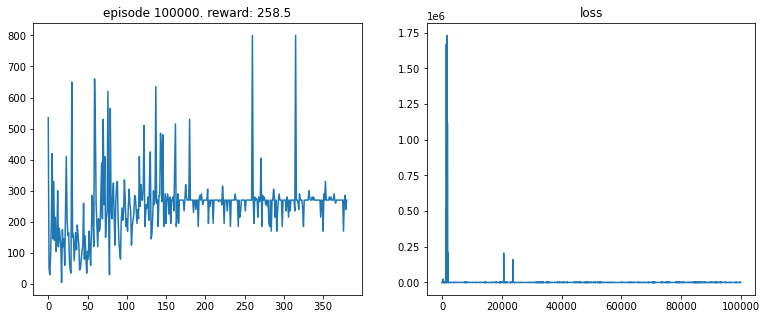

In [11]:
current_model, target_model, all_rewards, losses = train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = episodes, batch_size=batch_size, gamma = gamma, min_play_reward = min_play_reward)
torch.save(current_model.state_dict(), 'weights/spaceInvaders-hw-phi-skip-100k.pth')
torch.save(target_model.state_dict(), 'weights/spaceInvaders-target-hw-phi-skip-100k.pth')

# Inference : Use the trained model to play the game

In [13]:
import math, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import trange
from myDQN import DQN, ReplayBuffer, CNNDQN,DDQN

import torchvision.transforms as T
from PIL import Image

image_size = 84
transform = T.Compose([T.ToPILImage(),
                       T.Grayscale(num_output_channels=1),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

import queue
state_buffer = queue.Queue()
def get_state3(observation):
    
    # First time, repeat the state for 3 times
    if(state_buffer.qsize() == 0):
        for i in range(4):
            state = get_state2(observation)
            state_buffer.put(state)
        # print(observation.shape, state.shape)
    else:
        state_buffer.get()
        state = get_state2(observation)
        state_buffer.put(state)
    # for i in state_buffer.queue:
    #     print(i.shape)
    rep = torch.cat(list(state_buffer.queue), dim=0)
    # print("rep=====",rep.shape)
    return rep

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

# Select GPU or CPU as device
device = "cpu"
print(device)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)


env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

model = DDQN(4, env.action_space.n).to(device)
    
model.load_state_dict(torch.load('weights/spaceInvaders-hw-phi-skip-100k.pth', map_location=torch.device('cpu') ),)
model.eval()

# replay_buffer = ReplayBuffer(1000)

import time

def play_game_CNN(model):
    done = False
    obs = env.reset()
    state = get_state3(obs)
    round_reward = 0
    while(not done):
        action = model.act(state, epsilon_final,env,device)
        reward = 0
        for i in range(3):
            next_obs, i_reward, done, _ = env.step(action)
            # next_obs, reward, done, _ = env.step(action)
            reward += i_reward
            if(done): break
        round_reward += reward
        next_state = get_state3(next_obs)
        env.render()
        time.sleep(0.1)
        state = next_state
    return round_reward

reward_list = []

for i in range(100):
    reward = play_game_CNN(model)
    print(f"round {i}: {reward}")
    reward_list.append(reward)
# time.sleep(3)
env.close()
 
print("Reward:", sum(reward_list)/len(reward_list))

cpu
round 0: 270.0
round 1: 270.0
round 2: 270.0
round 3: 245.0
round 4: 235.0
round 5: 270.0
round 6: 270.0
round 7: 270.0
round 8: 285.0
round 9: 270.0
round 10: 270.0
round 11: 290.0
round 12: 270.0
round 13: 270.0
round 14: 270.0
round 15: 270.0
round 16: 270.0
round 17: 280.0
round 18: 270.0
round 19: 185.0
round 20: 300.0
round 21: 240.0
round 22: 280.0
round 23: 235.0
round 24: 270.0
round 25: 295.0
round 26: 205.0
round 27: 250.0
round 28: 270.0
round 29: 270.0
round 30: 270.0
round 31: 270.0
round 32: 270.0
round 33: 170.0
round 34: 295.0
round 35: 270.0
round 36: 270.0
round 37: 290.0
round 38: 270.0
round 39: 150.0
round 40: 275.0
round 41: 270.0
round 42: 270.0
round 43: 305.0
round 44: 270.0
round 45: 270.0
round 46: 270.0
round 47: 270.0
round 48: 280.0
round 49: 280.0
round 50: 270.0
round 51: 270.0
round 52: 270.0
round 53: 250.0
round 54: 200.0
round 55: 235.0
round 56: 270.0
round 57: 270.0
round 58: 270.0
round 59: 280.0
round 60: 270.0
round 61: 185.0
round 62: 270.